<a href="https://colab.research.google.com/github/zalscript/computer_vision/blob/master/IntelligenceDocumentProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intelligence Document Processing (IDP)


## Langkah 1: Instalasi Library (Wajib untuk Colab)

Jalankan cell di bawah ini untuk menginstal Tesseract OCR Engine dan Poppler (wajib untuk membaca PDF).

In [2]:
# Instalasi System Dependencies (Linux/Colab)
!sudo apt-get install -y tesseract-ocr poppler-utils

# Instalasi Python Libraries
!pip install pytesseract pdf2image opencv-python matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 1s (228 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously 

## Langkah 2: Import Library

In [3]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from pdf2image import convert_from_path

## Langkah 3: Definisi Fungsi Utilitas

Kita buat fungsi modular agar kode lebih rapi dan bisa menangani banyak halaman sekaligus.

In [4]:
def tampilkan_gambar(img, title="Gambar"):
    """Menampilkan gambar menggunakan Matplotlib"""
    plt.figure(figsize=(10, 8))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def extract_info_regex(text):
    """Mengekstrak informasi penting menggunakan Regex"""
    data = {}

    # 1. Cari Tanggal
    date_pattern = r'(\d{2}[-/]\d{2}[-/]\d{4})'
    date_match = re.search(date_pattern, text)
    data['Tanggal'] = date_match.group(1) if date_match else "-"

    # 2. Cari Total Harga
    total_pattern = r'(Total|Jumlah).*?(Rp[\s\.]?[\d\.,]+)'
    total_match = re.search(total_pattern, text, re.IGNORECASE)
    data['Total Bayar'] = total_match.group(2) if total_match else "-"

    return data


def process_image_cv(image_cv, page_num=1):
    """Proses satu gambar OpenCV: Preprocessing -> OCR -> Extraction -> Visualization"""
    print(f"\n--- Memproses Halaman {page_num} ---")

    # 1. Preprocessing (Grayscale + Thresholding)
    gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # 2. OCR Execution
    custom_config = r'--oem 3 --psm 6'
    raw_text = pytesseract.image_to_string(thresh, config=custom_config)
    ocr_data = pytesseract.image_to_data(thresh, output_type=pytesseract.Output.DICT, config=custom_config)

    print(f"[Teks Terdeteksi Hal {page_num}]:")
    print(raw_text.strip()[:1000] + "...") # Print 200 karakter pertama saja

    # 3. Information Extraction
    info = extract_info_regex(raw_text)
    print("[Hasil Ekstraksi]:", info)

    # 4. Visualisasi Kotak Deteksi
    img_overlay = image_cv.copy()
    n_boxes = len(ocr_data['text'])
    for i in range(n_boxes):
        if int(ocr_data['conf'][i]) > 60:
            (x, y, w, h) = (ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i])
            cv2.rectangle(img_overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)

    tampilkan_gambar(img_overlay, f"Hasil OCR Halaman {page_num}")

## Langkah 4: Eksekusi Utama (PDF atau Gambar)

Bagian ini otomatis mendeteksi apakah file tersebut PDF atau Gambar.


--- Memproses File: invoice.pdf ---
Mendeteksi PDF. Mengonversi halaman dari invoice.pdf...
Total 1 halaman ditemukan di invoice.pdf.

--- Memproses Halaman invoice.pdf - Halaman 1 ---
[Teks Terdeteksi Hal invoice.pdf - Halaman 1]:
Nota Pesanan
Nama Pembeli: .isal Nama Penjual: Sneakerzone Surabaya
Alamat Pembeli:
KP. CIBAREHONG RT 11/RW 12 (SAMPING CAHAYANA BAN), KAB. SUKABUMI, SURADE, JAWA
BARAT, ID, 43179
No. Handphone Pembeli: 6285846117250
No. Pesanan Tanggal Transaksi Metode Pembayaran Jasa Kirim
2407070GFTRKGW 10/07/24 coD Hemat
Rincian Pesanan
No. Produk Variasi Harga Produk = Kuantitas Subtotal
SEPATU FUTSAL SPECS METASALA RUELLE - METRO BL
1 SEPATU FUTSAL SPECS UE,41 Rp324.870 1 Rp324.870
Subtotal Rp324.870
Total Kuantitas (Aktif) 1 produk
Subtotal Pesanan Rp324.870
Subtotal Pengiriman Rp32.000
Biaya Layanan Rp12.667
Total Diskon Pengiriman -Rp30.000
Diskon Voucher Toko -Rp3.000
Diskon Voucher Shopee -Rp32.187
Total Pembayaran Rp304.350
Biaya-biaya yang ditagihkan oleh Shope

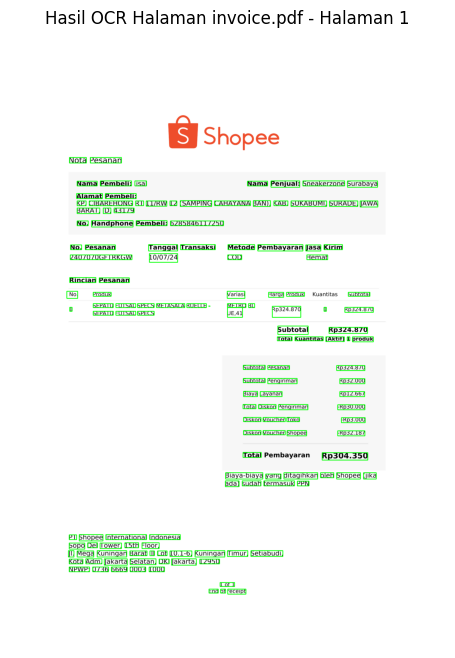


--- Memproses File: invoice_rotated.pdf ---
Mendeteksi PDF. Mengonversi halaman dari invoice_rotated.pdf...
Total 1 halaman ditemukan di invoice_rotated.pdf.

--- Memproses Halaman invoice_rotated.pdf - Halaman 1 ---
[Teks Terdeteksi Hal invoice_rotated.pdf - Halaman 1]:
2R=wWU er 2 N
22287 72 RE og z
EF Z3u 5 3 § Zz OnP 2 g
nos a x o by o 9
Vragsd Zs oD Po ao 5
oFe8 egy 3 38 £223 @
wo cde pea F a 8 5 Pt ov aA
ADTSO 5 FX ec ® 7p a O20 oO
arses ec x a 3s Me 3 >
B9Og20 a7 2 Zs aT wo
ano- 3 cc 3 za 3 wos 5 BS
oSsuy5 dd s 2 s h2ey ec
2 = 150
qnavs Pa o of =
Saowge 2 m7 =.
Seone 3% o 4 §
wee ao mm b o
e3i8s O83 rao 3 B
orP=Hos aw oo zr =
7 Oo g
Su5°8 = Ss 3 o zB
CRS 5 q a = =
—hr zB n@ a Bb
mo 2 5g a 2 NOON
x: o c s oO ~
Bie > aq a wv
+o Zz 9 o >
2% 7 3 & 3
os E g B 2
NB, m x e 2
c 683 6 g & —
a og - a oO
»
ar 3 ° 2 ~~»
2 oo
= 4d 2 czs
Be 5 oo mm & 82 z
2. 3 ~sS Az @ of >
® 5 £5 gd GSogeee g* 3 = TO
w ay 68 ge Rk gs f€ = = 2 ® o F
o Ve » o o9 =~ gg § 68
o a3 = 5 3 9 - gg ¢ u 3b 3 oO
» Te 2

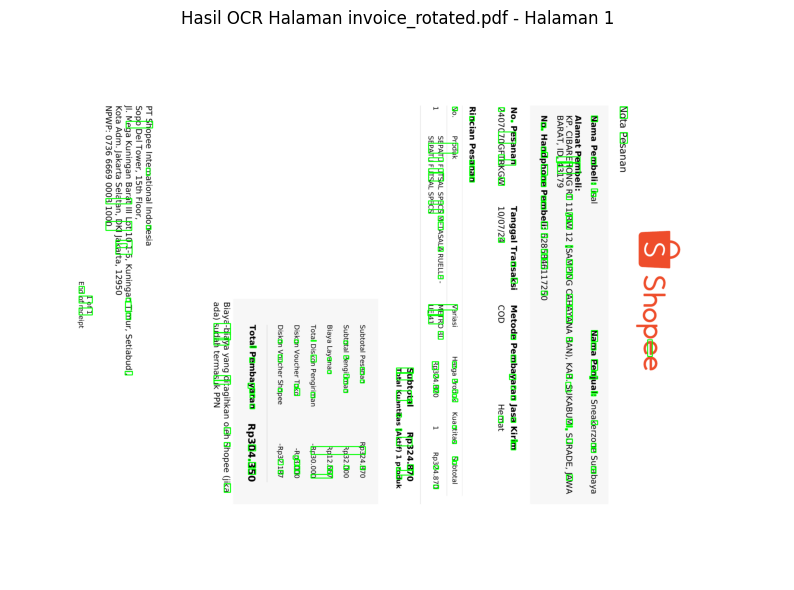

In [6]:
import os

file_paths = [
    '/content/invoice.pdf',
    '/content/invoice_rotated.pdf',
]

for file_path in file_paths:
    if not os.path.exists(file_path):
        print(f"File {file_path} tidak ditemukan! Silakan upload dulu dan pastikan namanya benar.")
        continue

    print(f"\n--- Memproses File: {os.path.basename(file_path)} ---")
    ext = os.path.splitext(file_path)[1].lower()

    if ext == '.pdf':
        print(f"Mendeteksi PDF. Mengonversi halaman dari {os.path.basename(file_path)}...")
        # Convert PDF ke List of PIL Images
        pages = convert_from_path(file_path)
        print(f"Total {len(pages)} halaman ditemukan di {os.path.basename(file_path)}.")

        for i, page_pil in enumerate(pages):
            # Convert PIL ke OpenCV Format (RGB -> BGR)
            page_cv = cv2.cvtColor(np.array(page_pil), cv2.COLOR_RGB2BGR)
            process_image_cv(page_cv, page_num=f"{os.path.basename(file_path)} - Halaman {i+1}")

    elif ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        print(f"Mendeteksi Gambar Tunggal: {os.path.basename(file_path)}.")
        image_cv = cv2.imread(file_path)
        if image_cv is None:
            print(f"Gagal membaca gambar {file_path}. Mungkin file rusak atau format tidak didukung.")
        else:
            process_image_cv(image_cv, page_num=f"{os.path.basename(file_path)}")

    else:
        print(f"Format file {file_path} tidak didukung.")

#Penjelasan Hasil

### 1. Invoice.pdf (Dokumen Normal)

Proses OCR mampu mengenali sebagian besar teks pada dokumen dengan baik. Informasi penting seperti judul Nota Pesanan, data penjual dan pembeli, rincian pesanan, subtotal, hingga total pembayaran dapat terbaca dengan cukup jelas dan rapi.

Hasil Ekstraksi Informasi:
- Tanggal: - (tidak berhasil diekstrak)
- Total Bayar: Rp324.870


Meskipun kualitas hasil OCR tergolong baik, proses ekstraksi data belum sepenuhnya akurat. Informasi tanggal gagal teridentifikasi, yang mengindikasikan bahwa pola pencarian untuk tanggal belum sesuai dengan format yang ada pada dokumen. Selain itu, nilai Total Bayar yang terambil sebesar Rp324.870 sebenarnya merupakan Subtotal Pesanan, bukan Total Pembayaran akhir yang bernilai Rp304.350. Hal ini menunjukkan bahwa aturan atau pola (regex) yang digunakan masih terlalu umum dan perlu diperjelas agar dapat membedakan antara subtotal dan total akhir secara lebih presisi.


###2. Invoice_rotated.pdf (Dokumen Terotasi)

Pada dokumen yang terotasi, OCR menghasilkan teks yang tidak terbaca atau acak. Kondisi ini wajar terjadi karena mungkin orientasi dokumen tidak sesuai, sehingga sistem OCR kesulitan mengenali bentuk karakter secara benar.

Hasil Ekstraksi Informasi:

- Tanggal: -
- Total Bayar: -

Karena teks hasil OCR tidak dapat dikenali dengan baik, tidak ada informasi penting yang berhasil diekstrak. Hal ini menunjukkan bahwa orientasi/angle dokumen sangat berpengaruh terhadap performa OCR.